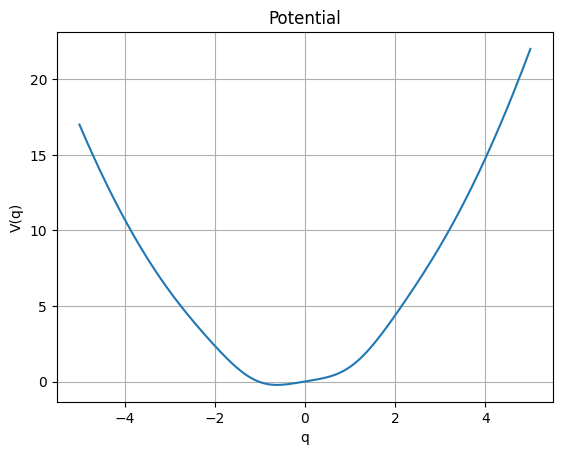

In [1]:
import jax.numpy as jnp

# Define the potential energy for the confined sinusoidal potential
def potential(q):
    # a, b = 1.0, 1.0  # Amplitudes for the sine terms
    # c = 0.2  # A small constant to keep the potential bounded
    # q1, q2 = .0, 20.0  # Positions to create minima
    # V = -a * jnp.sin(b * (q - q1))**2 - a * jnp.sin(b * (q - q2))**2 + c * q**2  # Combined potential
    # return V
    k1, k2 = 1.0, 0.5  # Spring constants for the two wells
    q1, q2 = -1.0, 1.0  # Positions of the wells
    V1 = 0.5 * k1 * (q - q1)**2  # Potential energy of the first well
    V2 = 0.5 * k2 * (q - q2)**2  # Potential energy of the second well
    V = -jnp.exp(-(q - q1)**2) - jnp.exp(-(q - q2)**2) + V1 + V2  # Combined potential
    return V

# Example usage:
import matplotlib.pyplot as plt

# Generate a range of q values
q_values = jnp.linspace(-5, 5, 400)
# Calculate potential values
V_values = potential(q_values)

# Plot the potential
plt.plot(q_values, V_values)
plt.xlabel('q')
plt.ylabel('V(q)')
plt.title('Potential')
plt.grid(True)
plt.show()

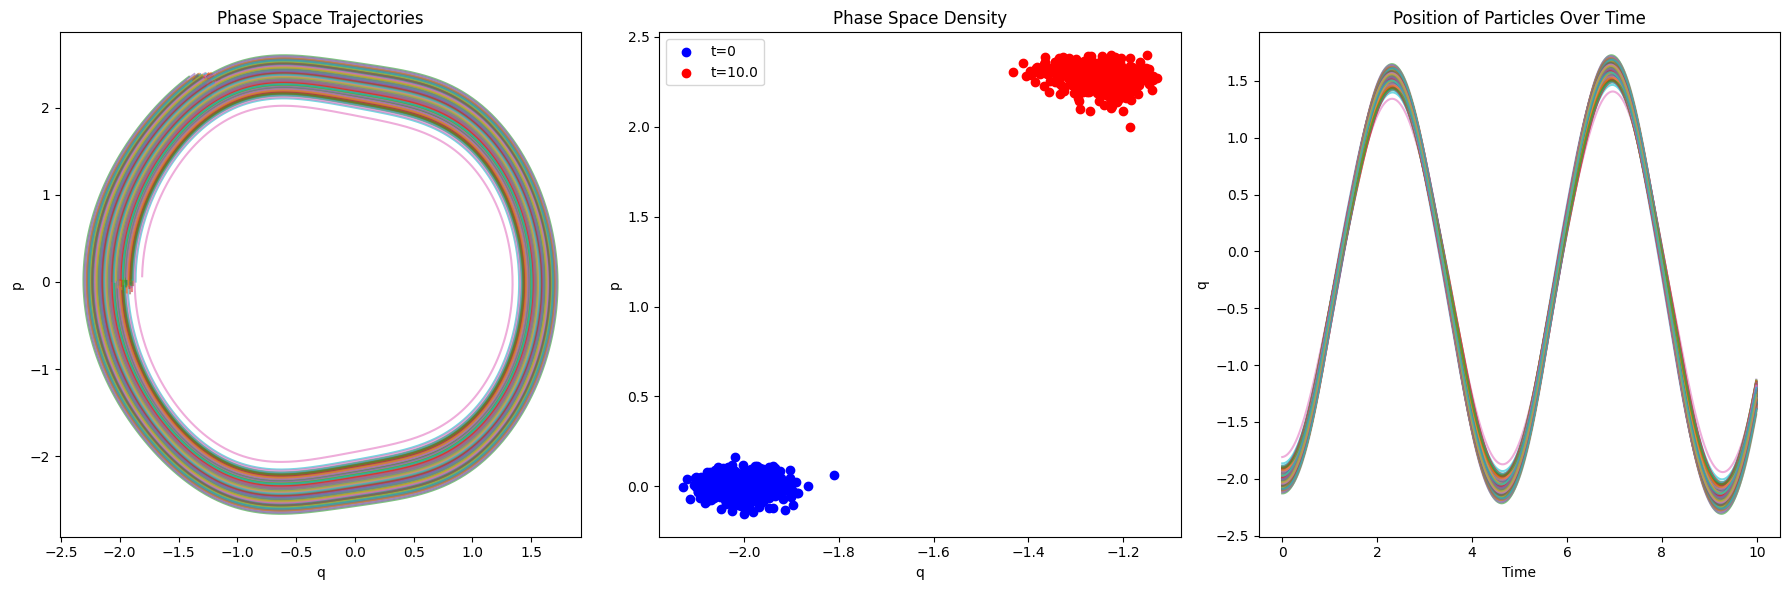

In [5]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the Hamiltonian for the system
def hamiltonian(q, p):
    m = 1.0  # mass
    T = p**2 / (2 * m)  # Kinetic energy
    V = potential(q)  # Potential energy
    return T + V

# Compute the equations of motion
def equations_of_motion(q, p):
    H_q = grad(hamiltonian, argnums=0)
    H_p = grad(hamiltonian, argnums=1)
    dq_dt = H_p(q, p)
    dp_dt = -H_q(q, p)
    return dq_dt, dp_dt

# Vectorize the equations of motion for multiple particles
vec_equations_of_motion = vmap(equations_of_motion, in_axes=(0, 0))

# Time evolution function using symplectic Euler method
@jit
def symplectic_euler_step(q, p, dt):
    dq_dt, dp_dt = vec_equations_of_motion(q, p)
    p_new = p + dp_dt * dt
    q_new = q + dq_dt * dt
    return q_new, p_new

# Initial conditions for multiple particles
num_particles = 500
#Random initial conditions at -2 with spread 0.1
key = jax.random.PRNGKey(0)
q_init = jax.random.normal(key, (num_particles,), dtype=jnp.float32) * 0.05 - 2.0
#q_init = jnp.linspace(-2, -1.9, num_particles)
#p_init = jnp.linspace(0, 0.1, num_particles)
key = jax.random.PRNGKey(1)
p_init = jax.random.normal(key, (num_particles,), dtype=jnp.float32) * 0.05 

# Time integration
dt = 0.01
num_steps = 1000

# Initialize arrays to store trajectories
q_traj = jnp.zeros((num_steps, num_particles))
p_traj = jnp.zeros((num_steps, num_particles))
q_traj = q_traj.at[0].set(q_init)
p_traj = p_traj.at[0].set(p_init)

# Integrate the equations of motion
q, p = q_init, p_init
for t in range(1, num_steps):
    q, p = symplectic_euler_step(q, p, dt)
    q_traj = q_traj.at[t].set(q)
    p_traj = p_traj.at[t].set(p)

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Phase space trajectories
for i in range(num_particles):
    ax[0].plot(q_traj[:, i], p_traj[:, i], alpha=0.6)
ax[0].set_xlabel('q')
ax[0].set_ylabel('p')
ax[0].set_title('Phase Space Trajectories')

# Density in phase space at initial and final time steps
ax[1].scatter(q_traj[0], p_traj[0], color='blue', label='t=0')
ax[1].scatter(q_traj[-1], p_traj[-1], color='red', label=f't={num_steps*dt}')
ax[1].set_xlabel('q')
ax[1].set_ylabel('p')
ax[1].set_title('Phase Space Density')
ax[1].legend()

# Position of particles over time
for i in range(num_particles):
    ax[2].plot(jnp.arange(num_steps) * dt, q_traj[:, i], alpha=0.6)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('q')
ax[2].set_title('Position of Particles Over Time')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


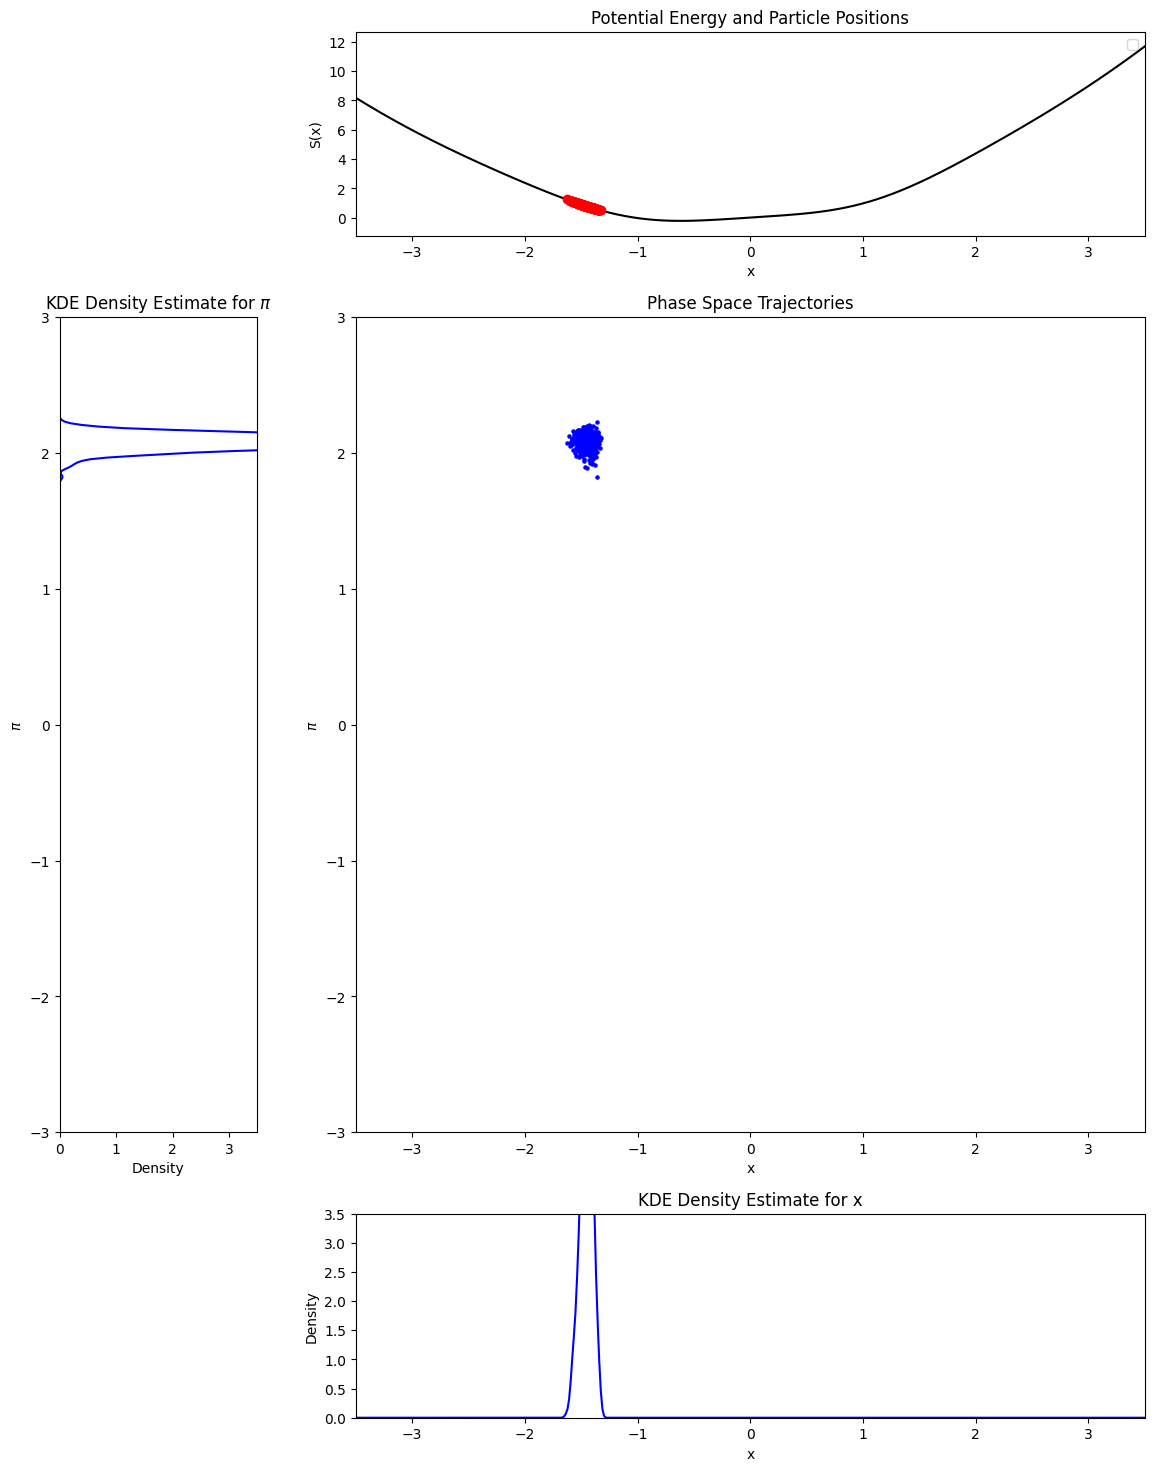

In [14]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import gaussian_kde

q_min, q_max = -3.5, 3.5
p_min, p_max = -3.0, 3.0

# Update function for the animation with marginal density plots
def update(frame):
    # Update scatter plot for phase space trajectories
    scatter.set_offsets(jnp.c_[q_traj[frame], p_traj[frame]])

    # Update particle positions on the potential energy plot
    particle_positions.set_data(q_traj[frame], potential(q_traj[frame]))

    # Compute and update KDE density estimate for q
    kde_q = gaussian_kde(q_traj[frame])
    q_kde_vals = jnp.linspace(-q_max, q_max, 500)
    kde_q_vals = kde_q(q_kde_vals)
    kde_q_line.set_data(q_kde_vals, kde_q_vals)

    # Compute and update KDE density estimate for p
    kde_p = gaussian_kde(p_traj[frame])
    p_kde_vals = jnp.linspace(p_min, p_max, 500)
    kde_p_vals = kde_p(p_kde_vals)
    kde_p_line.set_data(kde_p_vals, p_kde_vals)

    return scatter, particle_positions, kde_q_line, kde_p_line

# Create a figure and axis for the animation
fig, ax = plt.subplots(3, 2, figsize=(14, 18), gridspec_kw={'height_ratios': [1, 4, 1], 'width_ratios': [1, 4]})

# Prepare the potential plot
q_vals = jnp.linspace(q_min, q_max, 500)
V_vals = potential(q_vals)
ax[0, 1].plot(q_vals, V_vals, 'k-')
particle_positions, = ax[0, 1].plot([], [], 'ro')
ax[0, 1].set_xlim(q_min, q_max)
ax[0, 1].set_ylim(V_vals.min() - 1, V_vals.max() + 1)
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('S(x)')
ax[0, 1].set_title('Potential Energy and Particle Positions')
ax[0, 1].legend()

# Initialize the plots
scatter = ax[1, 1].scatter(q_traj[0], p_traj[0], c='blue', s=5)
ax[1, 1].set_xlim(q_min, q_max)
ax[1, 1].set_ylim(p_min, p_max)
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('$\pi$')
ax[1, 1].set_title('Phase Space Trajectories')

# KDE plot for q
kde_q_line, = ax[2, 1].plot([], [], 'b-', label='KDE Density for x')
ax[2, 1].set_xlim(q_min, q_max)
ax[2, 1].set_ylim(0, 3.5)
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('Density')
ax[2, 1].set_title('KDE Density Estimate for x')
#ax[2, 1].legend()

# KDE plot for p
kde_p_line, = ax[1, 0].plot([], [], 'b-', label='KDE Density for $\pi$')
ax[1, 0].set_xlim(0, 3.5)
ax[1, 0].set_ylim(p_min, p_max)
ax[1, 0].set_xlabel('Density')
ax[1, 0].set_ylabel('$\pi$')
ax[1, 0].set_title('KDE Density Estimate for $\pi$')
#ax[1, 0].legend()

# Hide the unused subplots
ax[0, 0].axis('off')
ax[2, 0].axis('off')

# Create the animation
# Reducing the number of frames by skipping steps for draft mode
skip_steps = 1
ani = animation.FuncAnimation(fig, update, frames=range(0, num_steps, skip_steps), interval=10, blit=True)

# To save the animation as a GIF (optional)
#ani.save('phase_space_animation.gif', writer='pillow')
ani.save('phase_space_animation.mp4', writer='ffmpeg')

plt.show()

/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_3685/3410022585.py:23: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  particle_position.set_data(q_single[frame], potential(q_single[frame]))
/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_3685/3410022585.py:23: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  particle_position.set_data(q_single[frame], potential(q_single[frame]))


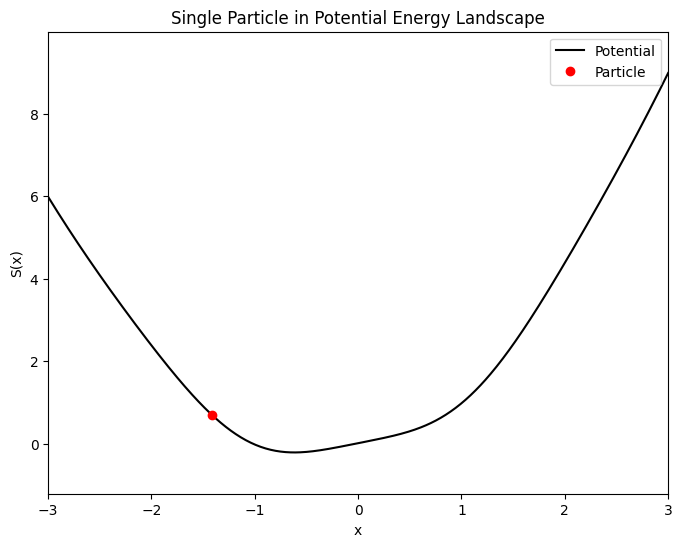

In [12]:
# Get the trajectory of the first particle
q_single = q_traj[:, 0]
p_single = p_traj[:, 0]

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Prepare the potential plot
q_vals = jnp.linspace(-3, 3, 500)
V_vals = potential(q_vals)
ax.plot(q_vals, V_vals, 'k-', label='Potential')
particle_position, = ax.plot([], [], 'ro', label='Particle')
ax.set_xlim(-3, 3)
ax.set_ylim(V_vals.min() - 1, V_vals.max() + 1)
ax.set_xlabel('x')
ax.set_ylabel('S(x)')
ax.set_title('Single Particle in Potential Energy Landscape')
ax.legend()

# Update function for the animation
def update(frame):
    # Update particle position on the potential energy plot
    particle_position.set_data(q_single[frame], potential(q_single[frame]))
    return particle_position,

# Create the animation
# Reducing the number of frames by skipping steps for draft mode
#skip_steps = 10
ani = animation.FuncAnimation(fig, update, frames=range(0, num_steps, skip_steps), interval=100, blit=True)

# To save the animation as a GIF (optional)
#ani.save('single_particle_animation.gif', writer='pillow')
ani.save('single_particle_animation.mp4', writer='ffmpeg')

plt.show()